# **Installation**

In [1]:
!pip install -q wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 100.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have te

## **Importing Required Libraries**

In [2]:
# Data Handling and Processing
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import pywt
from scipy import stats
import wfdb

# Machine Learning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix

# Deep Learning - Keras and TensorFlow
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

# Enable inline plotting
%matplotlib inline

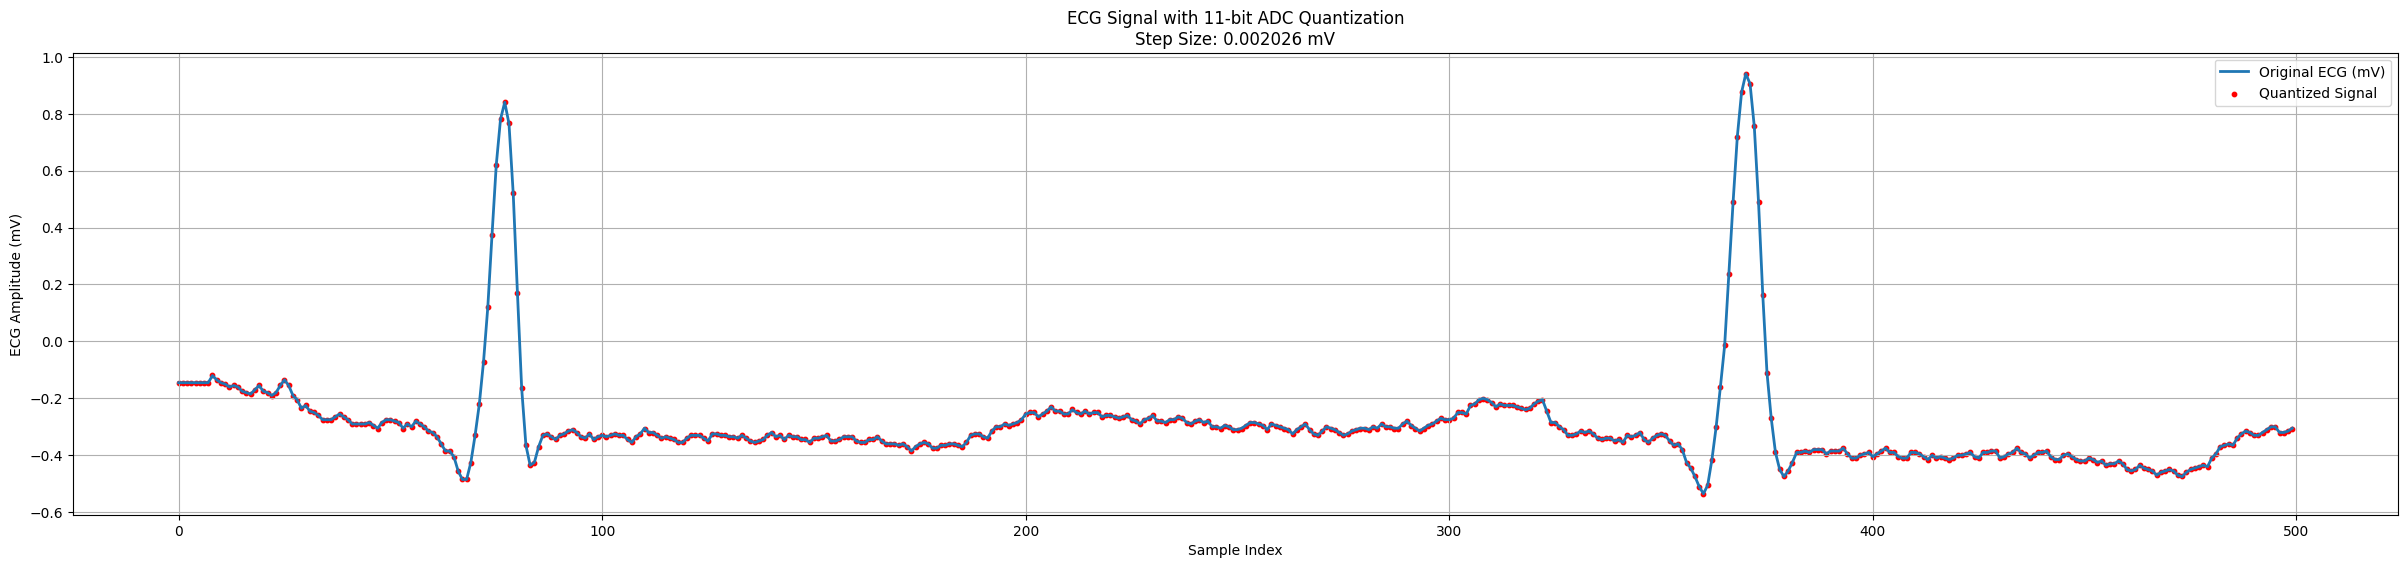

In [3]:
# Load ECG record (MIT-BIH 100)
record = wfdb.rdrecord("/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/100")

# Get Lead 1 signal (in mV)
ecg_signal = record.p_signal[:, 0]  # First lead

# Find min and max values
min_val, max_val = ecg_signal.min(), ecg_signal.max()
total_range = max_val - min_val

# Get ADC resolution
adc_bits = record.adc_res[0]
num_levels = 2 ** adc_bits  # 2^bits = total ADC levels
step_size = total_range / num_levels  # Step size in mV per level

# Generate quantization levels
quantized_levels = np.round(ecg_signal / step_size) * step_size  # Apply ADC quantization

# Plot ECG waveform
plt.figure(figsize=(30, 6))
plt.plot(ecg_signal[:500], label="Original ECG (mV)", linewidth=2)
plt.scatter(range(500), quantized_levels[:500], color='red', s=10, label="Quantized Signal")

# Add labels & legend
plt.xlabel("Sample Index")
plt.ylabel("ECG Amplitude (mV)")
plt.title(f"ECG Signal with {adc_bits}-bit ADC Quantization\nStep Size: {step_size:.6f} mV")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [4]:
# ADC -> Analog to digital conversion
import wfdb

record = wfdb.rdrecord("/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/100")  # Read MIT-BIH record
print(f"ADC Resolution: {record.adc_res} bits")
print(f"ADC Gain: {record.adc_gain}")  # Gain factor (μV per bit)


ADC Resolution: [11, 11] bits
ADC Gain: [200.0, 200.0]


In [5]:
# Directory name
dir_name = "MIT-BIH Arrhythmia"

# Check if the directory already exists
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
else:
    print(f"Directory '{dir_name}' already exists.")

Directory 'MIT-BIH Arrhythmia' created successfully.


In [6]:
def convert_to_csv(file_path, value):
    """
    Converts a WFDB record file to CSV format.

    Parameters:
    file_path (str): Path to the WFDB record file.
    value (str): Name for the output CSV file.

    Saves the signal data as a CSV file in the specified directory.
    """
    try:
        # Define output file path
        output_file = f"/kaggle/working/MIT-BIH Arrhythmia/{value}.csv"
        
        # Read the WFDB record
        record = wfdb.rdrecord(file_path)
        
        # Convert signal data to DataFrame
        signal_data = pd.DataFrame(record.p_signal, columns=record.sig_name)
        
        # Save DataFrame as CSV
        signal_data.to_csv(output_file, index=False)
        
        print(f"CSV file saved to: {output_file}")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [7]:
import wfdb

def convert_to_annotation(file_path, value):
    """
    Converts a WFDB annotation file to a text file.

    Parameters:
    file_path (str): Path to the WFDB record file (without extension).
    value (str): Name for the output annotation file.

    Saves the annotation data in a text file.
    """
    try:
        # Define output file path
        output_file = f"/kaggle/working/MIT-BIH Arrhythmia/{value}_annotation.txt"
        
        # Read the WFDB annotation file
        annotation = wfdb.rdann(file_path, 'atr')

        # Convert annotation data into a list of formatted strings
        annotation_data = [
            f"{idx} {sample} {annotation.symbol[idx]}" 
            for idx, sample in enumerate(annotation.sample)
        ]

        # Save annotations to a text file
        with open(output_file, "w") as f:
            f.write("\n".join(annotation_data))
        
        print(f"Annotations saved to: {output_file}")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [8]:
# Define the file path
file_path = "/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/RECORDS"

try:
    # Open the file and read all lines
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Clean the data by removing any leading/trailing whitespace
    cleaned_data = [line.strip() for line in lines]

    # Display the cleaned data
    print(cleaned_data)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [9]:
for file in cleaned_data:
    path = f'/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/{file}'
    convert_to_csv(path, file)
    convert_to_annotation(path, file)

CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/100.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/100_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/101.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/101_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/102.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/102_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/103.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/103_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/104.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/104_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/105.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/105_annotation.txt
CSV file saved to: /kaggle/working/MIT-BIH Arrhythmia/106.csv
Annotations saved to: /kaggle/working/MIT-BIH Arrhythmia/106_annotation.txt
CSV file saved to: /kaggle/working

In [10]:
def zip_folder(folder_path, zip_name):
    shutil.make_archive(zip_name, 'zip', folder_path)

folder_path = '/kaggle/working/MIT-BIH Arrythmia' 
zip_name = '/kaggle/working/MIT-BIH Arrythmia'
zip_folder(folder_path, zip_name)

## Sample View of the Data

In [11]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

## **Signal Denoising using Wavelet Transform**

### **Function: `denoise(data)`**
This function removes noise from a signal using **Wavelet Transform**. It applies **wavelet decomposition**, thresholds the coefficients, and reconstructs the signal to enhance its quality.

### **How It Works:**
1. **Choose Wavelet**: Uses the `'sym4'` (Symlet 4) wavelet.
2. **Determine Decomposition Level**: Computes the maximum level for wavelet decomposition.
3. **Apply Wavelet Decomposition**: Splits the signal into different frequency components.
4. **Thresholding**: Filters out small coefficients (assumed to be noise).
5. **Reconstruct the Signal**: Uses inverse wavelet transform to reconstruct the denoised signal.

In [12]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [13]:
base_path = '/kaggle/working/MIT-BIH Arrhythmia/'
window_size = 62
maximum_counting = 10000

classes = ['N', 'S', 'V', 'F', 'Q']

n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [14]:
filenames = next(os.walk(base_path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [15]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(base_path + filename + file_extension)

    # *.txt
    else:
        annotations.append(base_path + filename + file_extension)

In [16]:
signal = []
with open(records[1], 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    row_index = -1
    for row in spamreader:
        if row_index >= 0:
            signal.insert(row_index, int(float(row[0])))
        row_index += 1

print(f"The total number of rows: {len(signal)}")

The total number of rows: 650000


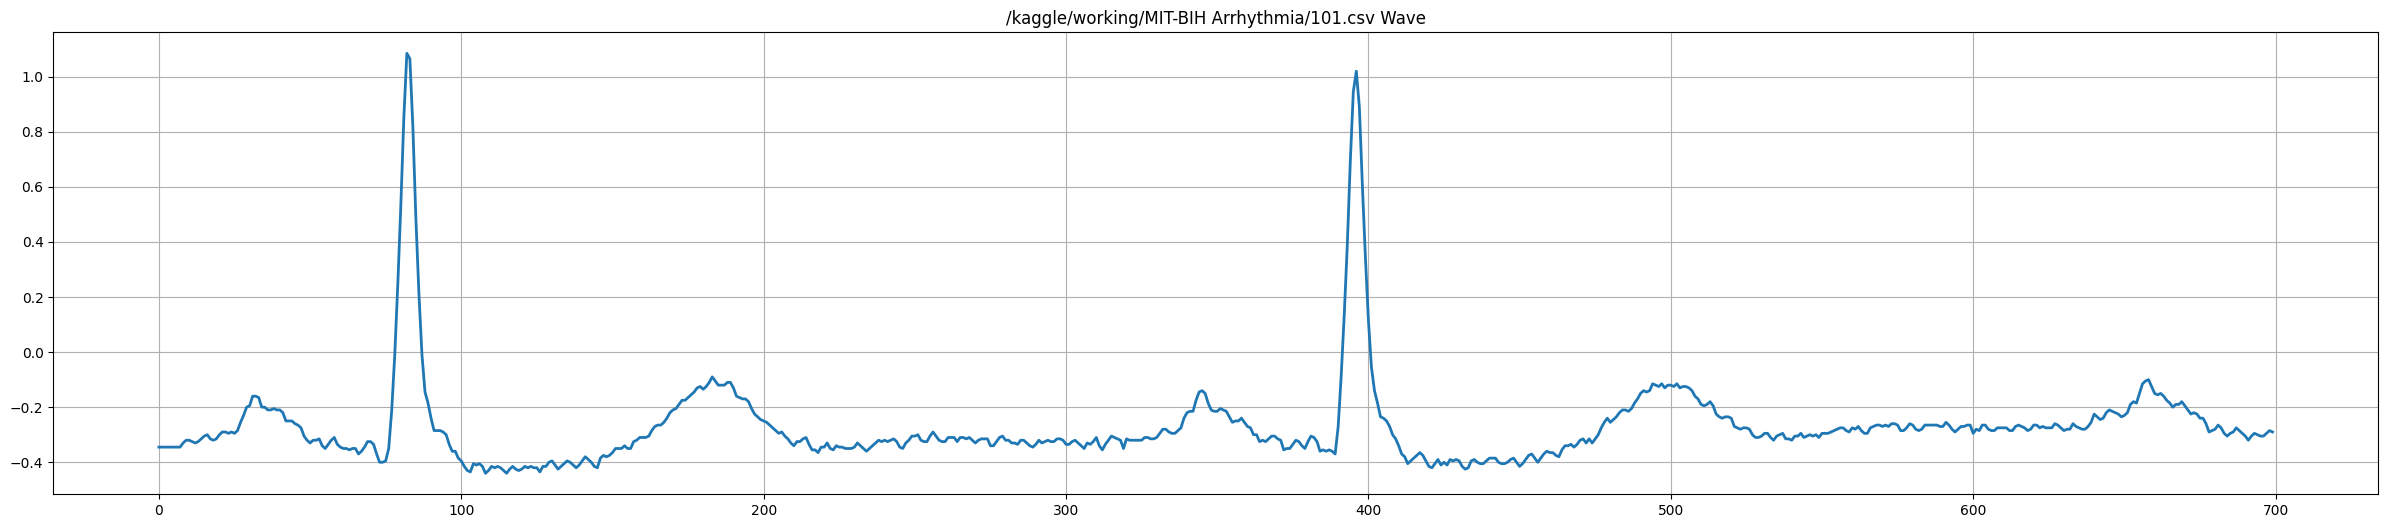

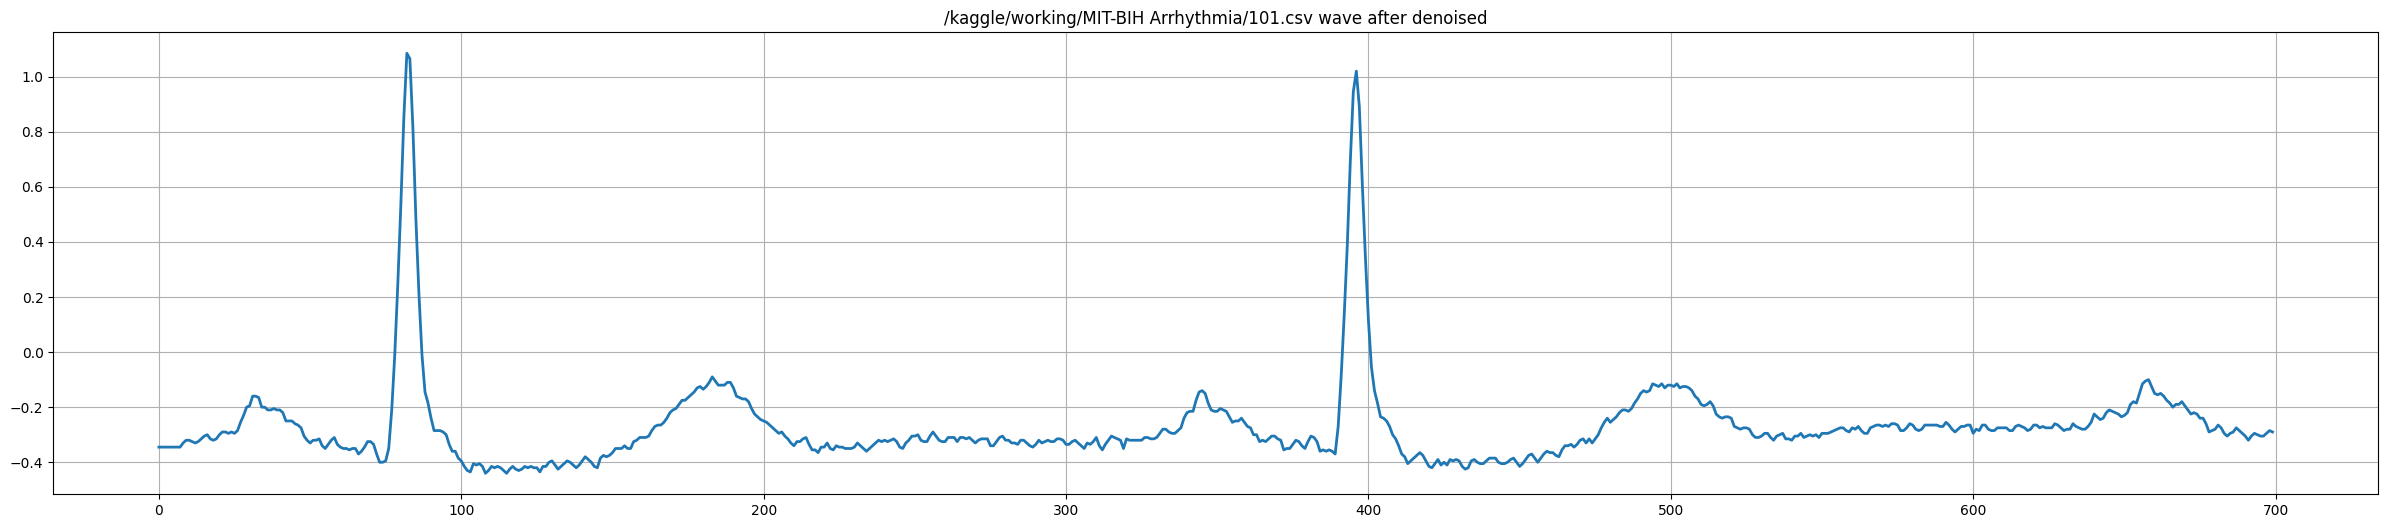

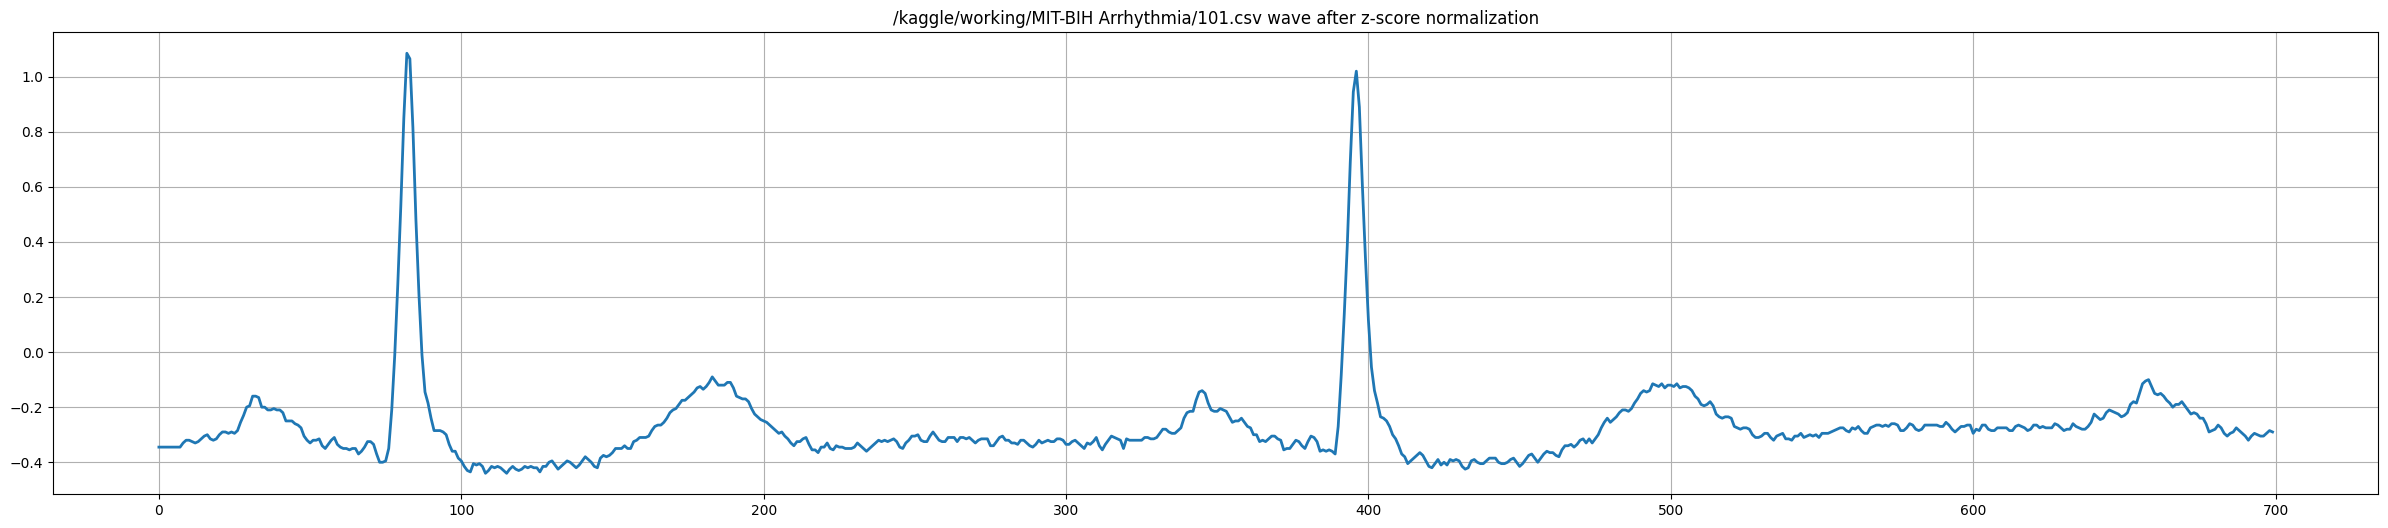

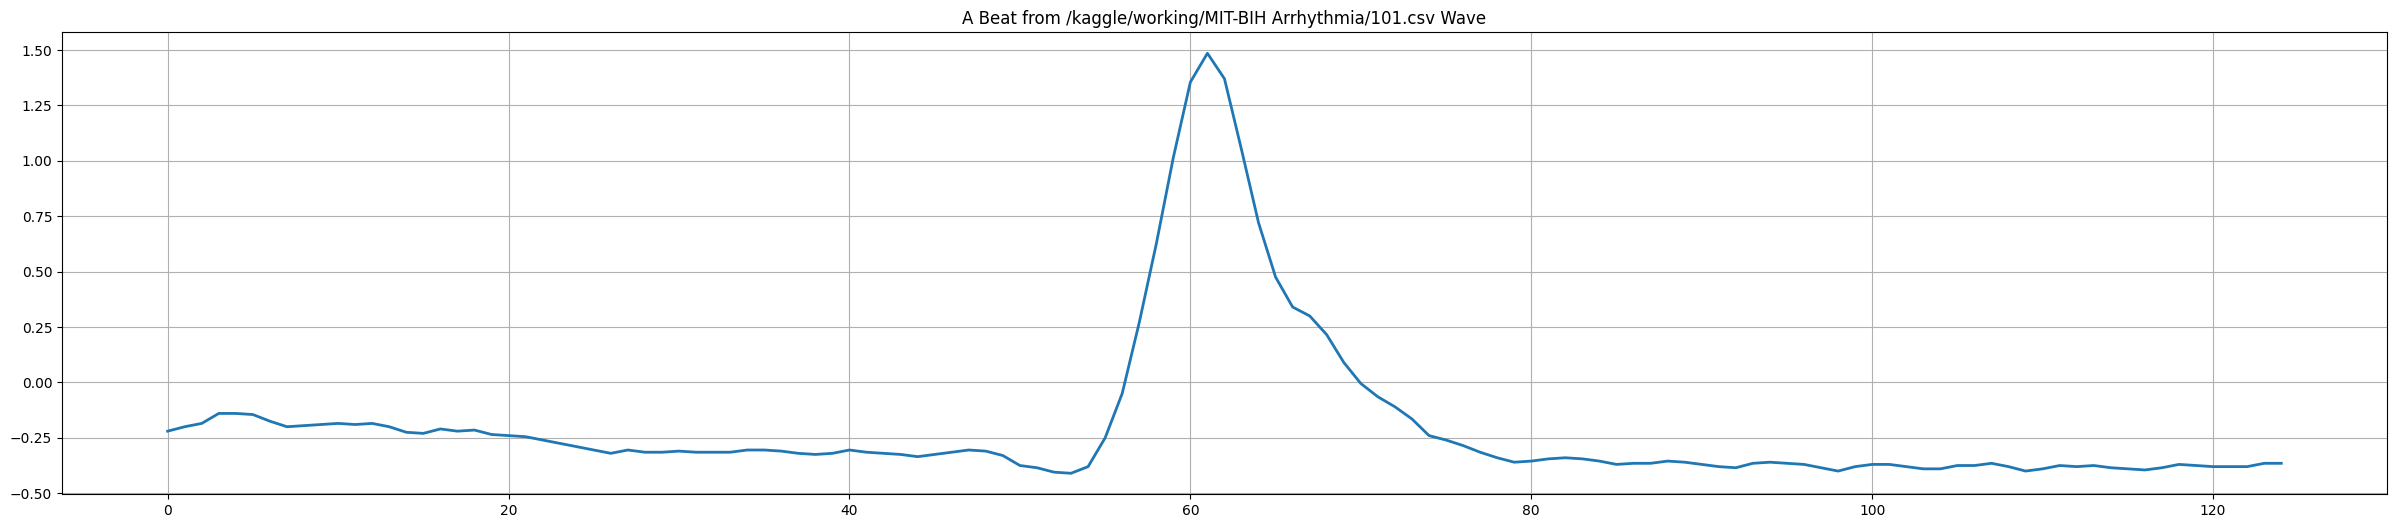

In [17]:
signal = []
beat = []

# Load the signal data from CSV file
with open(records[1], 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    row_index = -1
    for row in spamreader:
        if row_index >= 0:
            signal.insert(row_index, float(row[0]))
        row_index += 1

# Plot an example of the original signal
plt.title(records[1] + " Wave")
plt.plot(signal[0:700])
plt.show()

# Denoise the signal (make sure `denoise` is defined elsewhere)
signals = denoise(signal)

# Plot the denoised signal
plt.title(records[1] + " wave after denoised")
plt.plot(signal[0:700])
plt.show()

# Apply Z-score normalization
signals = stats.zscore(signals)

# Plot the signal after Z-score normalization
plt.title(records[1] + " wave after z-score normalization")
plt.plot(signal[0:700])
plt.show()

# Read annotations and extract relevant data
example_beat_printed = False
with open(annotations[1], 'r') as fileID:
    data = fileID.readlines()

    for d in range(1, len(data)):  # 0 index is Chart Head
        splitted = list(filter(None, data[d].split(' ')))  # Convert filter object to list
        pos = int(splitted[1])  # Sample ID
        arrhythmia_type = splitted[2]  # Type
        # print(arrhythmia_type)
        
        if arrhythmia_type in classes:
            arrhythmia_index = classes.index(arrhythmia_type)
            count_classes[arrhythmia_index] += 1

            if window_size <= pos < (len(signals) - window_size):
                beat = signal[pos - window_size:pos + window_size+1]  # Extract the beat

                # Plot an example beat
                if not example_beat_printed:
                    plt.title("A Beat from " + records[1] + " Wave")
                    plt.plot(beat)
                    plt.show()
                    example_beat_printed = True

In [18]:
for r in range(0,len(records)):
    signals = []
    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, float(row[0]))
            row_index += 1
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = []
        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            for cls in arrhythmia_type:
                if(cls in classes):
                    arrhythmia_index = classes.index(cls)
    
                    count_classes[arrhythmia_index] += 1
                    if(window_size <= pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size:pos+window_size+1]     ## REPLACE WITH R-PEAK DETECTION
                        X.append(beat)
                        y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(83008, 125) (83008,)


In [19]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(83008, 126)


In [20]:
X_train_df = pd.DataFrame(X)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-0.175,-0.180,-0.185,-0.170,-0.155,-0.175,-0.180,-0.190,-0.180,-0.155,...,-0.335,-0.340,-0.330,-0.340,-0.350,-0.355,-0.350,-0.345,-0.330,0.0
1,-0.200,-0.205,-0.215,-0.230,-0.220,-0.225,-0.225,-0.225,-0.230,-0.235,...,-0.405,-0.410,-0.390,-0.390,-0.385,-0.385,-0.410,-0.405,-0.395,0.0
2,-0.250,-0.240,-0.225,-0.215,-0.240,-0.245,-0.240,-0.245,-0.235,-0.245,...,-0.400,-0.400,-0.415,-0.425,-0.425,-0.415,-0.415,-0.410,-0.425,0.0
3,-0.245,-0.260,-0.265,-0.275,-0.280,-0.265,-0.270,-0.275,-0.280,-0.275,...,-0.395,-0.395,-0.385,-0.375,-0.375,-0.385,-0.395,-0.390,-0.390,0.0
4,-0.255,-0.245,-0.235,-0.255,-0.265,-0.260,-0.255,-0.270,-0.265,-0.280,...,-0.395,-0.395,-0.395,-0.400,-0.395,-0.395,-0.405,-0.405,-0.420,0.0


In [21]:
print(f"The Shape of the X_train_df: {X_train_df.shape}")

The Shape of the X_train_df: (83008, 126)


In [22]:
# Convert classes 1, 2, 3, and 4 into class 1, while keeping class 0 as it is
X_train_df.iloc[:, -1] = X_train_df.iloc[:, -1].apply(lambda x: 0 if x == 0 else 1)

# Filter rows for class 0 and class 1
class_0 = X_train_df[X_train_df.iloc[:, -1] == 0].sample(n=2500, random_state=42)
class_1 = X_train_df[X_train_df.iloc[:, -1] == 1].sample(n=2500, random_state=42)

# Concatenate the selected rows from class 0 and class 1
X_train_df_balanced = pd.concat([class_0, class_1])

# Optionally, shuffle the final DataFrame
data = X_train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
data

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-0.210,-0.205,-0.215,-0.220,-0.215,-0.210,-0.200,-0.190,-0.210,-0.220,...,-0.340,-0.345,-0.330,-0.320,-0.305,-0.330,-0.330,-0.340,-0.315,0.0
1,-0.220,-0.205,-0.195,-0.190,-0.195,-0.195,-0.210,-0.200,-0.190,-0.190,...,-0.005,0.000,0.000,0.005,-0.005,0.015,0.030,0.040,0.045,1.0
2,-0.015,0.025,0.050,0.090,0.090,0.110,0.155,0.180,0.195,0.215,...,-0.185,-0.170,-0.175,-0.180,-0.160,-0.125,-0.100,-0.085,-0.080,1.0
3,-0.135,-0.105,-0.070,-0.075,-0.070,-0.080,-0.100,-0.085,-0.070,-0.075,...,-0.270,-0.250,-0.260,-0.250,-0.250,-0.220,-0.195,-0.180,-0.170,0.0
4,-0.340,-0.315,-0.305,-0.280,-0.285,-0.265,-0.255,-0.235,-0.225,-0.205,...,-0.510,-0.530,-0.505,-0.495,-0.485,-0.480,-0.450,-0.455,-0.480,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.485,-0.500,-0.525,-0.510,-0.480,-0.445,-0.400,-0.350,-0.305,-0.270,...,-1.695,-1.715,-1.695,-1.675,-1.655,-1.645,-1.640,-1.640,-1.635,1.0
4996,-0.295,-0.290,-0.270,-0.280,-0.285,-0.300,-0.270,-0.290,-0.320,-0.345,...,-0.335,-0.320,-0.310,-0.290,-0.265,-0.240,-0.230,-0.235,-0.240,0.0
4997,-0.580,-0.565,-0.545,-0.540,-0.510,-0.490,-0.460,-0.445,-0.420,-0.395,...,0.560,0.580,0.615,0.640,0.645,0.665,0.680,0.685,0.710,1.0
4998,-0.190,-0.185,-0.170,-0.175,-0.185,-0.195,-0.200,-0.200,-0.190,-0.185,...,-0.110,-0.100,-0.080,-0.085,-0.080,-0.070,-0.050,-0.015,0.010,1.0


In [24]:
data.shape

(5000, 126)

In [25]:
data.iloc[:, -1].value_counts()

125
0.0    2500
1.0    2500
Name: count, dtype: int64